# Baseline-model experiments Michael

## Basic setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,\
    f1_score, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# remove max number of displayed df columns, since our data has quite many
# (default is 20)
pd.options.display.max_columns = None

## Load data

In [2]:
# merged_data.csv contains only complete observations (~ 450,000 of a total 2M)
# 'toxic' column = target! (1 if 'toxicity' >= 0.5)
#df = pd.read_csv('data/merged_data.csv')

# all_data.csv contains full dataset (only ~ 25% of which is labelled for
# identity)
df = pd.read_csv('data/all_data.csv')

# all_data.csv includes 4 rows with NaN in comment_text --> drop these
#print('# of rows before:', df.shape[0])
#display(df[df['comment_text'].isna()])
df.dropna(subset=['comment_text'], inplace=True)
#print('# of rows after:', df.shape[0])

# consider just a sample for experiments
df_sample = df#.sample(100_000)
df_sample.reset_index(inplace=True, drop=True)

X = df_sample['comment_text']
y = (df_sample['toxicity'] >= 0.5)

## Create variable to store experiment results
Can be viewed with VSC variable/data viewer.

In [3]:
experiments = [{'model_name': '',
                'data_len': 0,
                'auc': 0.0,
                'acc': 0.0,
                'f1': 0.0,
                'notes': ''}]
experiments.pop(0)

## Vectorize text columns

In [4]:
# simple bag of words
vectorizer = CountVectorizer()
X_vect = vectorizer.fit_transform(X)

In [5]:
print(type(X_vect))
print(X_vect.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(1999512, 336479)


## Split into train/test data

In [6]:
# default is 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X_vect, y)

## Logistic Regression

In [7]:
lr_clf = LogisticRegression(max_iter=2000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

              precision    recall  f1-score   support

       False       0.96      0.98      0.97    460183
        True       0.73      0.49      0.58     39695

    accuracy                           0.95    499878
   macro avg       0.85      0.74      0.78    499878
weighted avg       0.94      0.95      0.94    499878



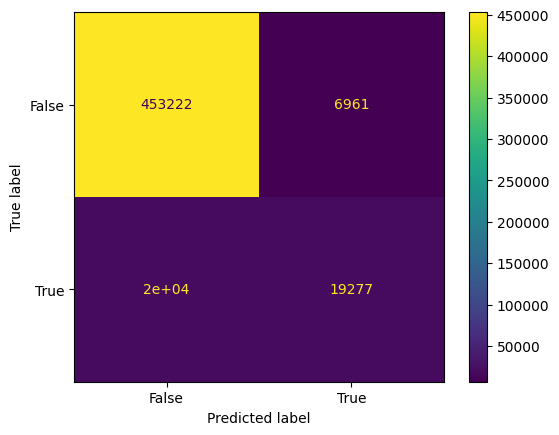

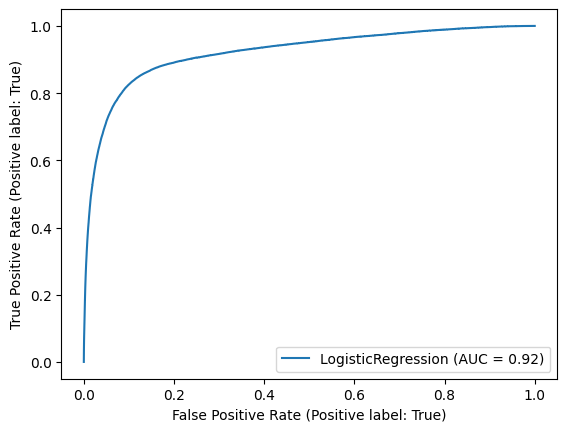

In [8]:
y_test_pred = lr_clf.predict(X_test)
y_test_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# Input for roc_auc_score() must be probabilities from .predict_proba,
# not predictions from .predict! There's no error raised and the result
# looks okay, although it's wrong! I've walked into this trap a couple
# of times during bootcamp, so watch out!
auc = roc_auc_score(y_test, y_test_pred_proba)

acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

experiments.append({'model_name': 'LogisticRegression',
                'data_len': X_train.shape[0],
                'auc': auc,
                'acc': acc,
                'f1': f1,
                'notes': 'max_iter=500'})

print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay.from_estimator(lr_clf, X_test, y_test)

RocCurveDisplay.from_estimator(lr_clf, X_test, y_test);

## DummyClassifier
### strategy='stratified'

              precision    recall  f1-score   support

       False       0.92      0.92      0.92    460183
        True       0.08      0.08      0.08     39695

    accuracy                           0.85    499878
   macro avg       0.50      0.50      0.50    499878
weighted avg       0.85      0.85      0.85    499878



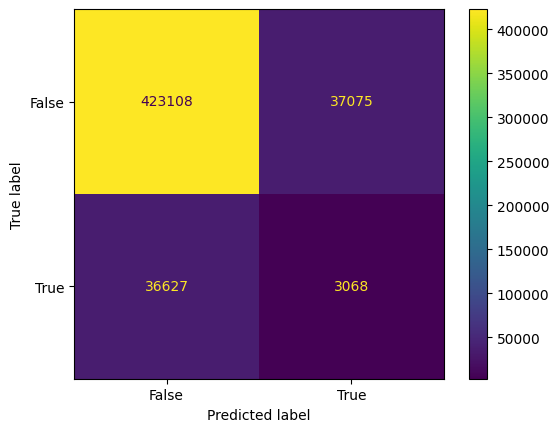

In [9]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)

y_test_pred = dummy_clf.predict(X_test)
y_test_pred_proba = dummy_clf.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_test_pred_proba)
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

experiments.append({'model_name': 'DummyClassifier',
                'data_len': X_train.shape[0],
                'auc': auc,
                'acc': acc,
                'f1': f1,
                'notes': 'strategy=stratified'})

print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay.from_estimator(dummy_clf, X_test, y_test);

### strategy='prior'
Default strategy, basically the same as 'most_frequent'.

/Users/mschick/nf-bootcamp/projects/lexyguards/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mschick/nf-bootcamp/projects/lexyguards/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.92      1.00      0.96    460183
        True       0.00      0.00      0.00     39695

    accuracy                           0.92    499878
   macro avg       0.46      0.50      0.48    499878
weighted avg       0.85      0.92      0.88    499878



/Users/mschick/nf-bootcamp/projects/lexyguards/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


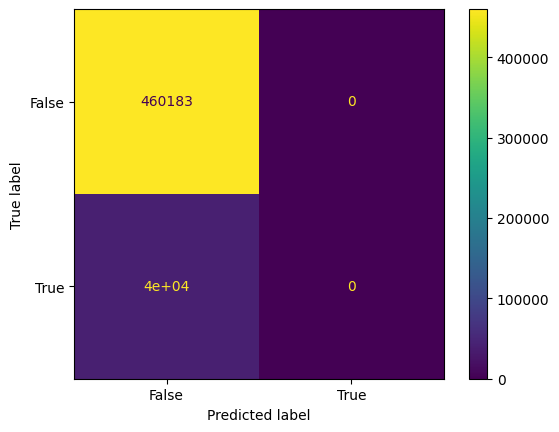

In [10]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)

y_test_pred = dummy_clf.predict(X_test)
y_test_pred_proba = dummy_clf.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_test_pred_proba)
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

experiments.append({'model_name': 'DummyClassifier',
                'data_len': X_train.shape[0],
                'auc': auc,
                'acc': acc,
                'f1': f1,
                'notes': 'strategy=prior'})

print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay.from_estimator(dummy_clf, X_test, y_test);